c:\IT3212\.venv\Lib\site-packages\pygam\pygam.py:2873: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y.ravel()
c:\IT3212\.venv\Lib\site-packages\pygam\pygam.py:2873: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y.ravel()


Linear Regression RMSE: 13.78
Additive Model RMSE: 43.99
SVR RMSE: 13.59
Random Forest RMSE: 77.70
Neural Network RMSE: 19.36


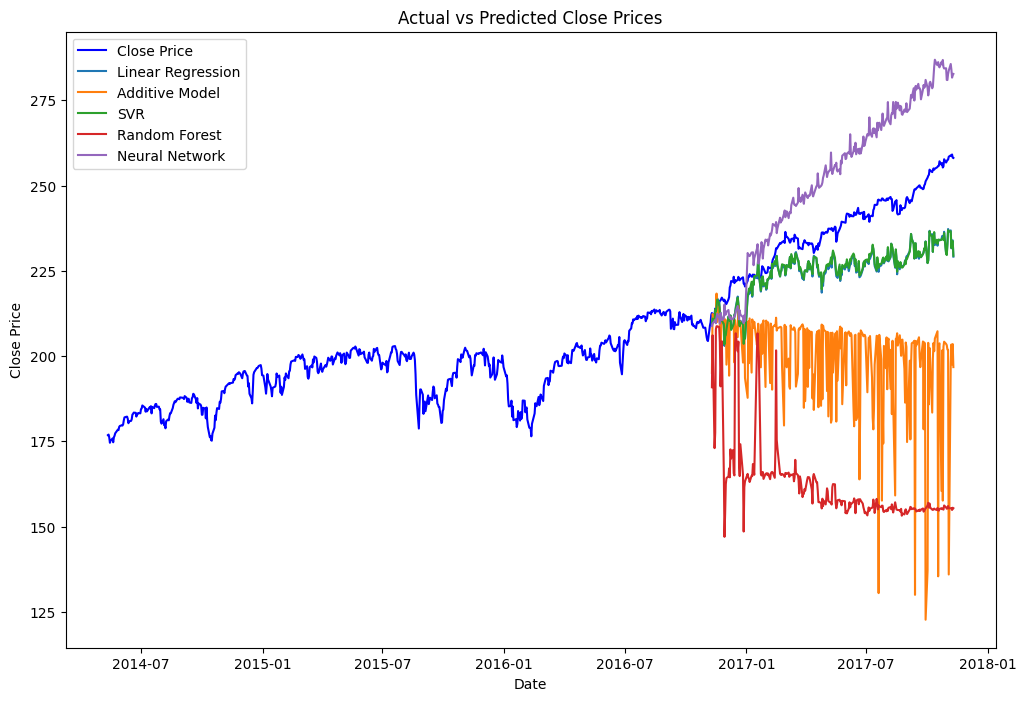

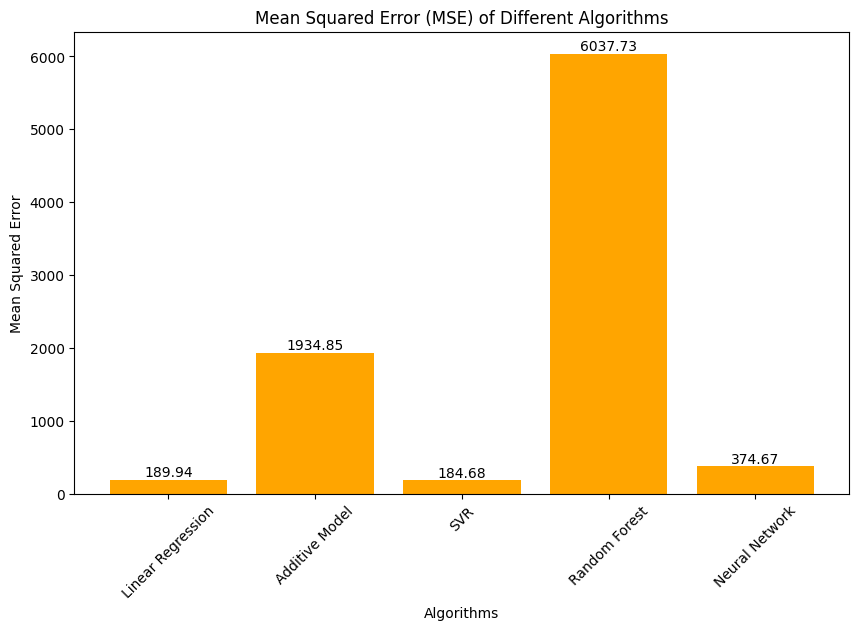

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, LogisticGAM, PoissonGAM, f, s
from sklearn import clone
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE


def create_date_features(df):
    """Create cyclical date features."""
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    """Add lagged features starting from min_lag to max_lag using optimized approach."""
    lagged_features = []  # List to store all lagged feature DataFrames
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            # Create a temporary DataFrame for the lagged feature
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature engineering: Create date-related, rolling, and lagged features
df = create_date_features(df)
# df = create_rolling_features(df, window_sizes=[10])
df = create_lagged_features(df, min_lag=20 * 16, max_lag=20 * 60)

# Drop irrelevant columns
df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'DayOfYear', 'WeekOfYear', 'Month'])

# Drop rows with NaN values (created by lagged and rolling features)
df.dropna(inplace=True)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < start_date]
test_X_normalized = X_normalized[X.index >= start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(
    np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2)
)
n_components = (
    np.argmax(cumulative_variance >= 0.95) + 1
)  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[: len(train_X)]
test_X_pls = X_pls[len(train_X) :]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[: len(train_X)]
test_X_rfe = X_rfe[len(train_X):]
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Additive Model": PoissonGAM(s(0, n_splines=10) + f(1), fit_intercept=True),
    "SVR": SVR(kernel="linear", C=100, epsilon=5),
    # Optimized Random Forest Regressor
    "Random Forest": RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features="sqrt",
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    "Neural Network": MLPRegressor(
        hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01
    ),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model="additive", period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions and store MSE values for each model
predictions = {}
mse_values = {}
for name, model in models.items():
    if name == "Linear Regression":
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X) :]
    else:
        model.fit(train_X_rfe, train_y if name == "Additive Model" else train_y)
        pred = model.predict(test_X_rfe)
        if name == "Additive Model":
            model.fit(train_X_rfe, train_y)

    predictions[name] = pred

    # Calculate MSE for each model and store it in mse_values dictionary
    mse_values[name] = mean_squared_error(test_y, pred)

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df["Actual"] = test_y

# Calculate and display RMSE for each model and print MSE values for bar chart plotting
for name in predictions.keys():
    rmse = np.sqrt(mse_values[name])
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(
    df_last_3_years.index, df_last_3_years["Close"], label="Close Price", color="blue"
)

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
bars = plt.bar(list(mse_values.keys()), list(mse_values.values()), color="orange")

plt.title("Mean Squared Error (MSE) of Different Algorithms")
plt.ylabel("Mean Squared Error")
plt.xlabel("Algorithms")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )  # Position the text at the center of the bar and just above it

plt.show()

In [ ]:
from pygam import LinearGAM
from sklearn.base import BaseEstimator, RegressorMixin

class SklearnCompatibleLinearGAM(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.gam_params = kwargs
        self.model = None

    def fit(self, X, y):
        self.model = LinearGAM(**self.gam_params)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)
    
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

boostpred = {}
boostmse = {}

# Loop through each model in the models dictionary and apply AdaBoost
for name, model in models.items():
    if name == "Additive Model":
        # Use the SklearnCompatibleLinearGAM wrapper
        gam_wrapper = SklearnCompatibleLinearGAM()
        boosted_model = AdaBoostRegressor(
            estimator=gam_wrapper, n_estimators=50, random_state=42
        )
    else:
        # Use AdaBoost with the current model as the base estimator
        boosted_model = AdaBoostRegressor(
            estimator=model, n_estimators=50, random_state=42
        )

    # Fit the boosted model on the training data
    boosted_model.fit(train_X_rfe, train_y)

    # Make predictions on the test set
    pred = boosted_model.predict(test_X_rfe)

    # Store predictions and MSE for each boosted model
    boostpred["Boosting " + name] = pred
    boostmse["Boosting " + name] = mean_squared_error(test_y, pred)

# Calculate and display RMSE for each boosted model
for name in boostpred.keys():
    rmse = np.sqrt(boostmse[name])
    print(f"{name} RMSE: {rmse:.2f}")



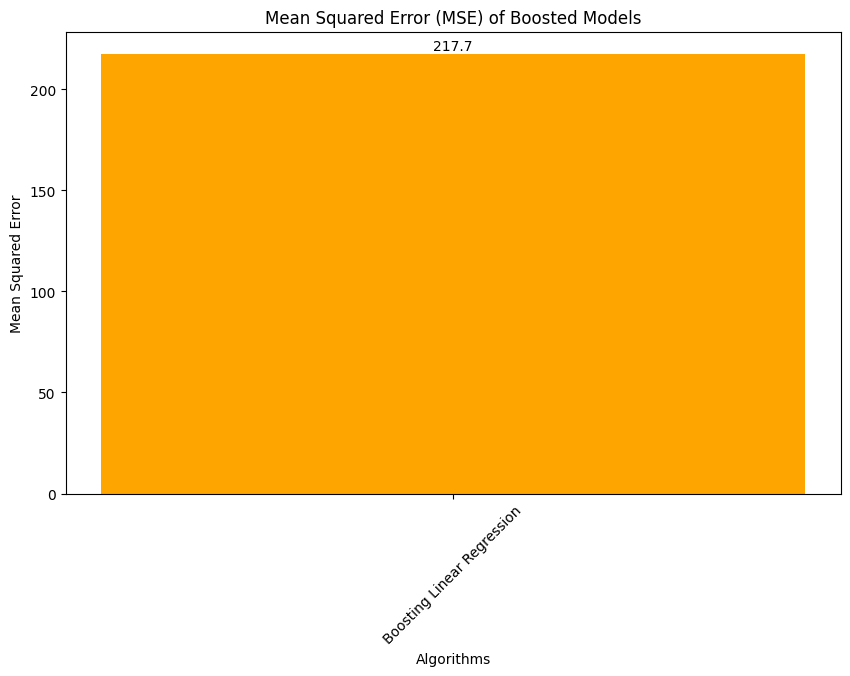

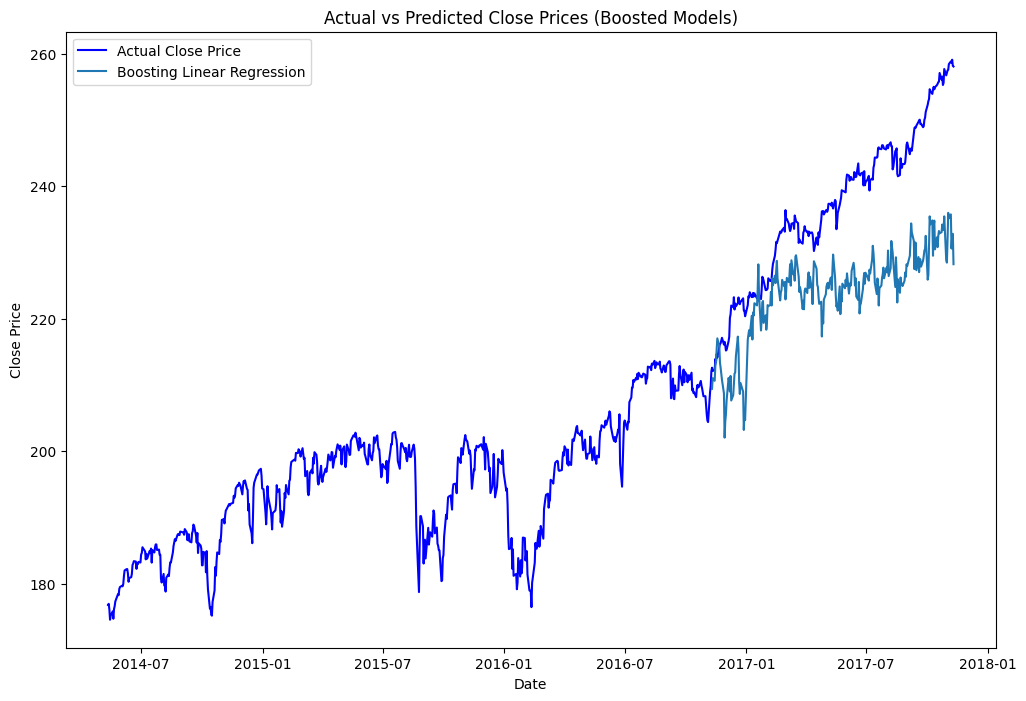

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot MSE values for Boosted models
plt.figure(figsize=(10, 6))
bars = plt.bar(list(boostmse.keys()), list(boostmse.values()), color="orange")

plt.title("Mean Squared Error (MSE) of Boosted Models")
plt.ylabel("Mean Squared Error")
plt.xlabel("Algorithms")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )  # Position text at center of bar

plt.show()

# Plot Actual vs Predicted Prices (Boosted models)
plt.figure(figsize=(12, 8))

# Plot actual close price
plt.plot(df_last_3_years.index, df_last_3_years["Close"], label="Actual Close Price", color="blue")

# Plot predictions from each boosted model
for name, pred in boostpred.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices (Boosted Models)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming AdaBoostRegressor is already trained with base models (like SVR, etc.)
# Get predictions from each base model (estimators) in the AdaBoostRegressor
base_model_predictions_boosting = np.array([estimator.predict(test_X_rfe) for estimator in boosted_model.estimators_])

# List of base model names for boosting (you can customize this)
base_model_names_boosting = ["SVR"] * len(boosted_model.estimators_)  # Example for SVR, adjust for your base models

# Create a figure with 2 subplots: one for predictions and one for residuals (scatter plot)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot patterns (predictions) from each base model
for i, pred in enumerate(base_model_predictions_boosting):
    axes[0].plot(test_y.index, pred,  alpha=0.5)

axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
axes[0].set_title("Predictions from Each Base Model (AdaBoost) in AdaBoostRegressor")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Predicted Value")
axes[0].legend(loc="best")

# Plot residuals as scatter plots for each base model
for i, pred in enumerate(base_model_predictions_boosting):
    residuals = test_y - pred
    axes[1].scatter(pred, residuals, alpha=0.5)

axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title("Residuals from Each Base Model (AdaBoost) (Scatter Plot)")
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].legend(loc="best")

# Show the side-by-side plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import BaggingRegressor
# Initialize dictionaries to store bagged predictions and MSE values
bagpred = {}
bagmse = {}

# Loop through each model in the models dictionary
for name, model in models.items():
    if name == "Linear Regression":
        # For Linear Regression, we can directly bag it
        bagging_model = BaggingRegressor(
            estimator=model,  # Use Linear Regression as the base estimator
            n_estimators=50,  # Number of base estimators
            random_state=42,
        )
        bagging_model.fit(train_X_rfe, train_y)  # Fit on training data

        # Generate predictions on test set
        pred = bagging_model.predict(test_X_rfe)

    elif name == "Additive Model":
        # continue
                # Ensure Additive Model is compatible
        bagging_model = BaggingRegressor(
            estimator= model,  # Use Additive Model as the base estimator
            n_estimators=50,  # Number of base estimators
            random_state=42,
            n_jobs=-1  # Use all CPU cores for parallel processing
        )
        bagging_model.fit(train_X_rfe, train_y)  # Fit on training data

    else:
        # For other models, wrap them in a Bagging Regressor
        bagging_model = BaggingRegressor(
            estimator=model,  # Base estimator
            n_estimators=50,  # Number of base estimators
            random_state=42,
        )
        bagging_model.fit(train_X_rfe, train_y)  # Fit on training data

        # Generate predictions on test set
        pred = bagging_model.predict(test_X_rfe)

    # Store predictions and MSE values for each bagged model
    bagpred["Bagging " + name] = pred
    bagmse["Bagging " + name] = mean_squared_error(test_y, pred)

# Calculate and display RMSE for each bagged model
for name in bagpred.keys():
    rmse = np.sqrt(bagmse[name])
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices including Bagged Linear Regression model
plt.figure(figsize=(12, 8))
plt.plot(
    df_last_3_years.index, df_last_3_years["Close"], label="Close Price", color="blue"
)

# Plot each model's predictions including Bagged models
for name, pred in bagpred.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices (Bagged Models)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot MSE values for Bagged models
plt.figure(figsize=(10, 6))
bars = plt.bar(list(bagmse.keys()), list(bagmse.values()), color="orange")

plt.title("Mean Squared Error (MSE) of Bagged Algorithms")
plt.ylabel("Mean Squared Error")
plt.xlabel("Algorithms")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )  # Position text at center of bar

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Assuming `bagging_model` is already trained with base estimators like Linear Regression
# Get predictions from each base model (estimators)
base_model_predictions = np.array([estimator.predict(test_X_rfe) for estimator in bagging_model.estimators_])

# List of base model names (you can customize this based on your actual models)
base_model_names = ["Linear Regression"] * len(bagging_model.estimators_)  # Example for Linear Regression

# Create a figure with 2 subplots: one for predictions and one for residuals (scatter plot)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot patterns (predictions) from each base model
for i, pred in enumerate(base_model_predictions):
    axes[0].plot(test_y.index, pred,  alpha=0.5)

axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
axes[0].set_title("Predictions from Each Base Model (Linear Regression) in BaggingRegressor")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Predicted Value")
axes[0].legend(loc="best")

# Plot residuals as scatter plots for each base model
for i, pred in enumerate(base_model_predictions):
    residuals = test_y - pred
    axes[1].scatter(pred, residuals,  alpha=0.5)

axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title("Residuals from Each Base Model (Linear) (Scatter Plot)")
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].legend(loc="best")

# Show the side-by-side plots
plt.tight_layout()
plt.show()


c:\IT3212\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 13761.4561
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2294.0325
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1870.4669
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1176.5397
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 932.8814
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 609.3313
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 521.7632
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 508.5308
Epoch 9/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 440.0799
Epoch 10/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 469.1863
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 692.6926
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4246
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0870
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0720
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2

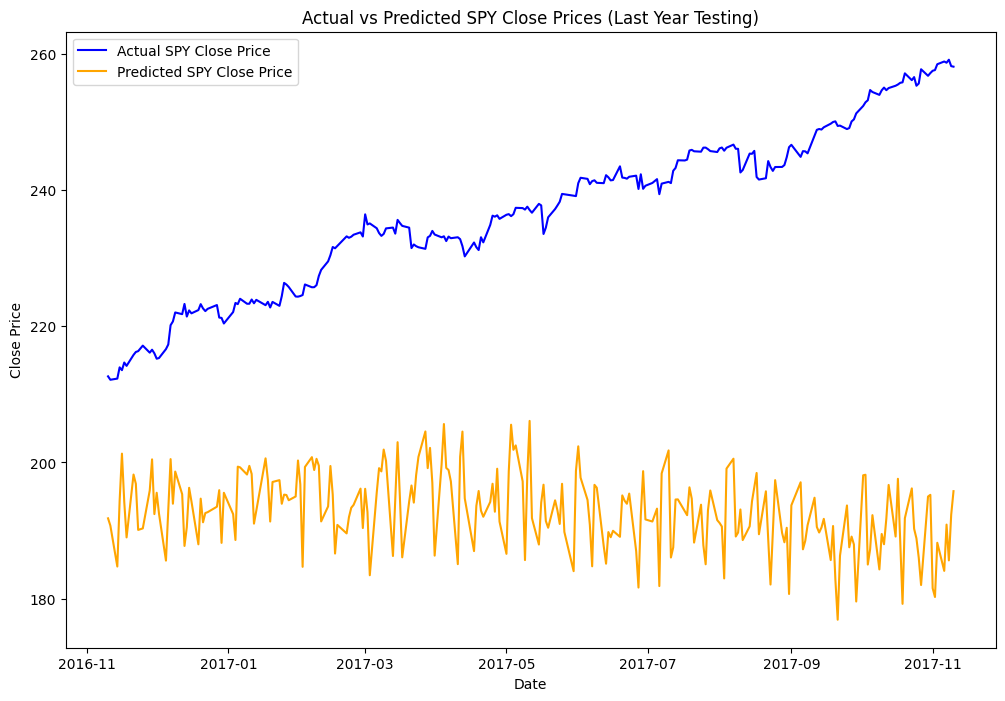

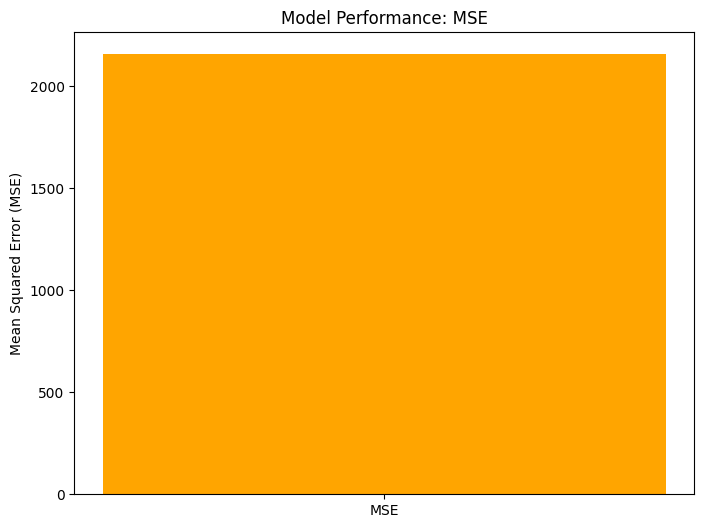

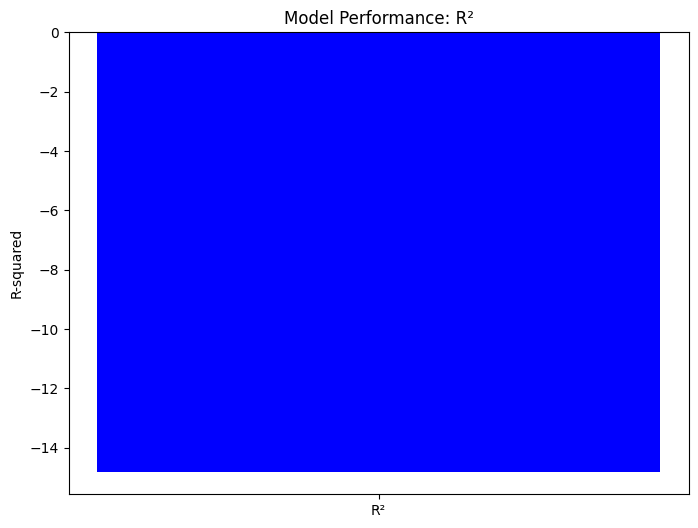

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.metrics import mean_squared_error, r2_score

def load_and_preprocess_data(ticker_symbol, start_date=None, end_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'], index_col='Date')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    
    hist = hist[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    
    if start_date:
        start_date = pd.to_datetime(start_date).tz_localize(hist.index.tz)
        hist = hist[hist.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).tz_localize(hist.index.tz)
        hist = hist[hist.index <= end_date]
    
    return hist

def create_lagged_features(df, min_lag, max_lag):
    lagged_features = []
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    return df.dropna()

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(1, input_shape)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Load and preprocess data
spy_data = load_and_preprocess_data("SPY")
spy_end_date = spy_data.index.max()
spy_test_start_date = spy_end_date - timedelta(days=365)

dji_data = load_and_preprocess_data("^HSI", end_date=spy_test_start_date)

# Create lagged features
spy_data = create_lagged_features(spy_data, min_lag=20 * 16, max_lag=20 * 60)
dji_data = create_lagged_features(dji_data, min_lag=20 * 16, max_lag=20 * 60)

# Split SPY data
spy_train_data = spy_data[spy_data.index < spy_test_start_date]
spy_test_data = spy_data[spy_data.index >= spy_test_start_date]

# Prepare features and target
feature_columns = [col for col in spy_data.columns if col != 'Close' and col != 'Open' and col != 'High' and col != 'Low']
X_columns = feature_columns
y_column = 'Close'

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers on training data
scaler_X.fit(spy_train_data[X_columns])
scaler_y.fit(spy_train_data[[y_column]])

# Transform all data
dji_X = scaler_X.transform(dji_data[X_columns])
dji_y = scaler_y.transform(dji_data[[y_column]])

spy_train_X = scaler_X.transform(spy_train_data[X_columns])
spy_train_y = scaler_y.transform(spy_train_data[[y_column]])

spy_test_X = scaler_X.transform(spy_test_data[X_columns])
spy_test_y = scaler_y.transform(spy_test_data[[y_column]])

# Reshape input data for LSTM (samples, time steps, features)
dji_X = dji_X.reshape((dji_X.shape[0], 1, dji_X.shape[1]))
spy_train_X = spy_train_X.reshape((spy_train_X.shape[0], 1, spy_train_X.shape[1]))
spy_test_X = spy_test_X.reshape((spy_test_X.shape[0], 1, spy_test_X.shape[1]))

# Create and train the model
model = create_lstm_model(dji_X.shape[2])
model.fit(dji_X, dji_y, epochs=10, batch_size=32, verbose=1)
model.fit(spy_train_X, spy_train_y, epochs=10, batch_size=32, verbose=1)

# Make predictions
spy_predictions_scaled = model.predict(spy_test_X)
spy_predictions = scaler_y.inverse_transform(spy_predictions_scaled)
spy_y_test_true = scaler_y.inverse_transform(spy_test_y)

# Calculate metrics
mse = mean_squared_error(spy_y_test_true, spy_predictions)
r2 = r2_score(spy_y_test_true, spy_predictions)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")
print(f"LSTM Model R² on SPY Test Data (Last Year): {r2}")

# Plot results
plt.figure(figsize=(12, 8))
last_3_years = spy_data.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = spy_data[spy_data.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_test_data.index, spy_predictions, label="Predicted SPY Close Price", color='orange')
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(8, 6))
plt.bar(['MSE'], [mse], color='orange')
plt.title('Model Performance: MSE')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

# Plot R-squared
plt.figure(figsize=(8, 6))
plt.bar(['R²'], [r2], color='blue')
plt.title('Model Performance: R²')
plt.ylabel('R-squared')
plt.show()

c:\IT3212\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 0.0084
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 2.9414e-04
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 2.9578e-04
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 2.3139e-04
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 2.2388e-04
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 1.9499e-04
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 2.1758e-04
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 1.8748e-04
Epoch 9/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 1.5940e-04
Epoch 10/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 1.6496e-04
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 2.9316e-06
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 6.1245e-09
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 5.8864e-09
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 5.54

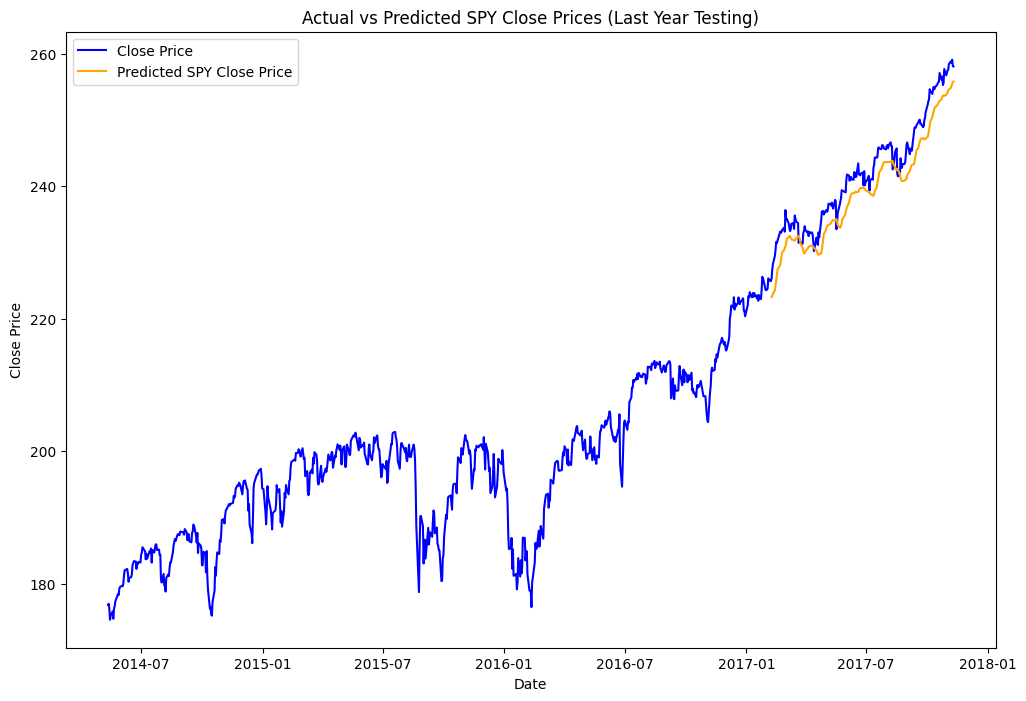

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# Function to load and preprocess data with specific columns only
def load_and_preprocess_data(ticker_symbol, start_date=None, end_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'], index_col='Date')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    
    # Keep only the required columns
    hist = hist[['Open', 'High', 'Low', 'Close']].dropna()
    
    # Filter data by date range if specified
    if start_date:
        start_date = pd.to_datetime(start_date).tz_localize(hist.index.tz)
        hist = hist[hist.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).tz_localize(hist.index.tz)
        hist = hist[hist.index <= end_date]
    
    return hist

# Load SPY data and define the date range for the last year (testing data)
spy_data = load_and_preprocess_data("SPY")
spy_end_date = spy_data.index.max()
spy_test_start_date = spy_end_date - timedelta(days=365)  # Approximate one year

# Load DJI data for pretraining up to the start of the SPY testing period
dji_data = load_and_preprocess_data("^HSI", end_date=spy_test_start_date)

# Scale both datasets using the same scaler
scaler = MinMaxScaler()
dji_data_scaled = scaler.fit_transform(dji_data)
spy_data_scaled = scaler.transform(spy_data)

# Helper function to create sequences for LSTM
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])  # 'Close' is at index 3 after selecting columns
    return np.array(sequences), np.array(targets)

# Create sequences for LSTM input
seq_length = 60
dji_X, dji_y = create_sequences(dji_data_scaled, seq_length)

# Build LSTM model
def create_lstm_model(input_shape):
    model = Sequential([ 
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and pretrain the LSTM model on DJI data
lstm_model = create_lstm_model((dji_X.shape[1], dji_X.shape[2]))
lstm_model.fit(dji_X, dji_y, epochs=10, batch_size=32, verbose=1)

# Split SPY data into training (up to test start) and testing (last year)
spy_train_data = spy_data[spy_data.index < spy_test_start_date]
spy_test_data = spy_data[spy_data.index >= spy_test_start_date]

# Scale SPY training and testing data using the same scaler
spy_train_scaled = scaler.transform(spy_train_data)
spy_test_scaled = scaler.transform(spy_test_data)

# Create sequences for SPY training and testing data
spy_X_train, spy_y_train = create_sequences(spy_train_scaled, seq_length)
spy_X_test, spy_y_test = create_sequences(spy_test_scaled, seq_length)

# Fine-tune the pretrained model on SPY training data
lstm_model.fit(spy_X_train, spy_y_train, epochs=10, batch_size=32, verbose=1)

# Generate predictions on SPY testing data
spy_predictions_scaled = lstm_model.predict(spy_X_test)
spy_predictions = scaler.inverse_transform(np.hstack((np.zeros((spy_predictions_scaled.shape[0], 3)), spy_predictions_scaled)))[:, -1]

# Inverse scale the actual test values for comparison
spy_y_test_true = scaler.inverse_transform(np.hstack((np.zeros((spy_y_test.reshape(-1, 1).shape[0], 3)), spy_y_test.reshape(-1, 1))))[:, -1]

# Calculate Mean Squared Error for the test period
mse = mean_squared_error(spy_y_test_true, spy_predictions)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")

# Plot actual vs predicted SPY Close prices for the testing period
plt.figure(figsize=(12, 8))
last_3_years = spy_data.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = spy_data[spy_data.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_test_data.index[seq_length:], spy_predictions, label="Predicted SPY Close Price", color="orange")
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
